In [8]:
import pandas as pd
import numpy as np

# Noms de colonnes d'après wdbc.names
columns = [
    "id", "diagnosis",
    "radius_mean", "texture_mean", "perimeter_mean", "area_mean",
    "smoothness_mean", "compactness_mean", "concavity_mean",
    "concave_points_mean", "symmetry_mean", "fractal_dimension_mean",
    "radius_se", "texture_se", "perimeter_se", "area_se",
    "smoothness_se", "compactness_se", "concavity_se",
    "concave_points_se", "symmetry_se", "fractal_dimension_se",
    "radius_worst", "texture_worst", "perimeter_worst", "area_worst",
    "smoothness_worst", "compactness_worst", "concavity_worst",
    "concave_points_worst", "symmetry_worst", "fractal_dimension_worst"
]

data = pd.read_csv("wdbc.data", header=None, names=columns)

# Cible binaire: M = 1 (malin), B = 0 (bénin)
data["diagnosis"] = data["diagnosis"].map({"M": 1, "B": 0})

# Séparation X / y
X = data.drop(["id", "diagnosis"], axis=1)
y = data["diagnosis"]

print("Shape X:", X.shape)
print("Shape y:", y.shape)
print("Classes:", np.bincount(y))


Shape X: (569, 30)
Shape y: (569,)
Classes: [357 212]


In [9]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42,
    stratify=y  # important si léger déséquilibre
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [10]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

def eval_classif(model_name, y_true, y_pred, y_proba=None):
    print("=== ", model_name, " ===")
    print("Accuracy :", accuracy_score(y_true, y_pred))
    print("Precision:", precision_score(y_true, y_pred))
    print("Recall   :", recall_score(y_true, y_pred))
    print("F1-score :", f1_score(y_true, y_pred))
    if y_proba is not None:
        print("ROC AUC  :", roc_auc_score(y_true, y_proba))
    print()


In [11]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(
    penalty="l2",
    max_iter=10000,
    solver="lbfgs"
)
log_reg.fit(X_train_scaled, y_train)

y_pred_lr = log_reg.predict(X_test_scaled)
y_proba_lr = log_reg.predict_proba(X_test_scaled)[:, 1]

eval_classif("Logistic Regression", y_test, y_pred_lr, y_proba_lr)


===  Logistic Regression  ===
Accuracy : 0.9707602339181286
Precision: 0.9836065573770492
Recall   : 0.9375
F1-score : 0.96
ROC AUC  : 0.997517523364486



In [12]:
from sklearn.svm import SVC

svm_rbf = SVC(
    kernel="rbf",
    probability=True,
    random_state=42
)
svm_rbf.fit(X_train_scaled, y_train)

y_pred_svm = svm_rbf.predict(X_test_scaled)
y_proba_svm = svm_rbf.predict_proba(X_test_scaled)[:, 1]

eval_classif("SVM RBF", y_test, y_pred_svm, y_proba_svm)


===  SVM RBF  ===
Accuracy : 0.9590643274853801
Precision: 1.0
Recall   : 0.890625
F1-score : 0.9421487603305785
ROC AUC  : 0.9972254672897196



In [13]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=500,
    max_features="sqrt",
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)
y_proba_rf = rf.predict_proba(X_test)[:, 1]

eval_classif("Random Forest", y_test, y_pred_rf, y_proba_rf)


===  Random Forest  ===
Accuracy : 0.9707602339181286
Precision: 1.0
Recall   : 0.921875
F1-score : 0.959349593495935
ROC AUC  : 0.9962032710280373



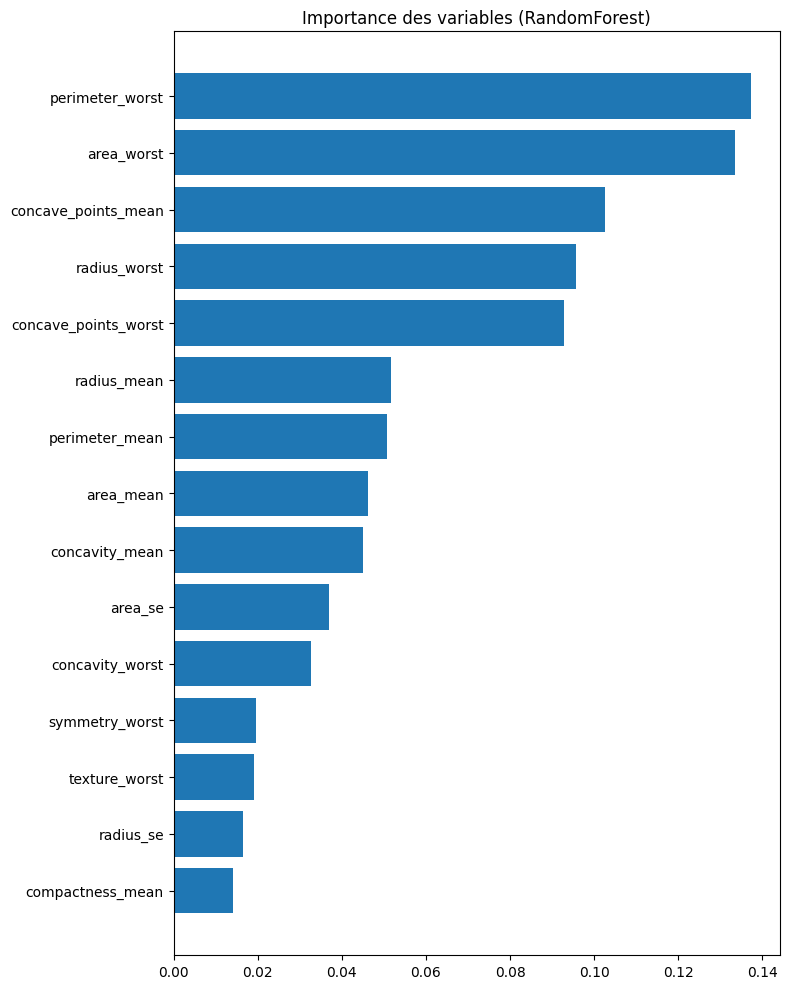

In [14]:
import numpy as np
import matplotlib.pyplot as plt

importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(8, 10))
plt.title("Importance des variables (RandomForest)")
plt.barh(range(15), importances[indices][:15][::-1])
plt.yticks(range(15), X.columns[indices][:15][::-1])
plt.tight_layout()
plt.show()


In [15]:
k = 10  # à faire varier : 5, 10, 15…
top_k_features = X.columns[indices][:k]

X_train_k = X_train[top_k_features]
X_test_k = X_test[top_k_features]

rf_k = RandomForestClassifier(
    n_estimators=500,
    max_features="sqrt",
    random_state=42,
    n_jobs=-1
)
rf_k.fit(X_train_k, y_train)

y_pred_rf_k = rf_k.predict(X_test_k)
y_proba_rf_k = rf_k.predict_proba(X_test_k)[:, 1]

eval_classif(f"Random Forest (top {k} features)", y_test, y_pred_rf_k, y_proba_rf_k)


===  Random Forest (top 10 features)  ===
Accuracy : 0.9532163742690059
Precision: 0.9827586206896551
Recall   : 0.890625
F1-score : 0.9344262295081968
ROC AUC  : 0.9926985981308412



In [16]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    "n_estimators": [200, 500],
    "max_depth": [None, 5, 10],
    "max_features": ["sqrt", "log2"]
}

grid_rf = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid,
    cv=5,
    scoring="f1",
    n_jobs=-1
)

grid_rf.fit(X_train, y_train)

print("Meilleurs hyperparamètres RF:", grid_rf.best_params_)
best_rf = grid_rf.best_estimator_

y_pred_best_rf = best_rf.predict(X_test)
y_proba_best_rf = best_rf.predict_proba(X_test)[:, 1]

eval_classif("Random Forest (tuned)", y_test, y_pred_best_rf, y_proba_best_rf)


Meilleurs hyperparamètres RF: {'max_depth': None, 'max_features': 'log2', 'n_estimators': 200}
===  Random Forest (tuned)  ===
Accuracy : 0.9707602339181286
Precision: 1.0
Recall   : 0.921875
F1-score : 0.959349593495935
ROC AUC  : 0.9957651869158879



In [17]:
results = pd.DataFrame({
    "Model": [
        "Logistic Regression",
        "SVM RBF",
        "Random Forest",
        f"Random Forest (top {k})",
        "Random Forest (tuned)"
    ],
    "Accuracy": [
        accuracy_score(y_test, y_pred_lr),
        accuracy_score(y_test, y_pred_svm),
        accuracy_score(y_test, y_pred_rf),
        accuracy_score(y_test, y_pred_rf_k),
        accuracy_score(y_test, y_pred_best_rf)
    ],
    "F1": [
        f1_score(y_test, y_pred_lr),
        f1_score(y_test, y_pred_svm),
        f1_score(y_test, y_pred_rf),
        f1_score(y_test, y_pred_rf_k),
        f1_score(y_test, y_pred_best_rf)
    ]
})

print(results)


                    Model  Accuracy        F1
0     Logistic Regression  0.970760  0.960000
1                 SVM RBF  0.959064  0.942149
2           Random Forest  0.970760  0.959350
3  Random Forest (top 10)  0.953216  0.934426
4   Random Forest (tuned)  0.970760  0.959350


In [18]:
from sklearn.model_selection import cross_val_score, StratifiedKFold

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scores = cross_val_score(
    best_rf,  # ou log_reg
    X, y,
    cv=cv,
    scoring="f1"
)

print("Scores F1 CV (5-fold):", scores)
print("Moyenne F1:", scores.mean())
print("Écart-type F1:", scores.std())


Scores F1 CV (5-fold): [0.95454545 0.91358025 0.95       0.95454545 0.95121951]
Moyenne F1: 0.9447781336399224
Écart-type F1: 0.015702665362968573


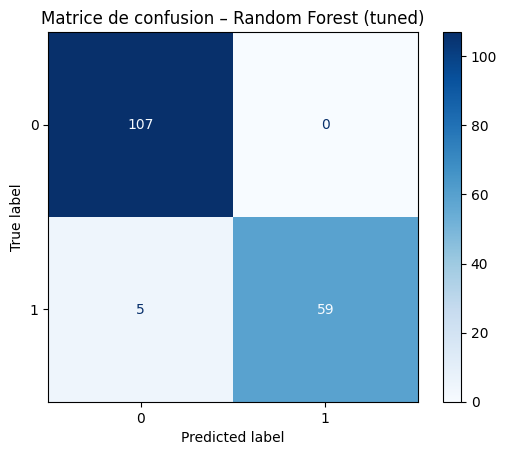

In [19]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred_best_rf)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap="Blues")
plt.title("Matrice de confusion – Random Forest (tuned)")
plt.show()


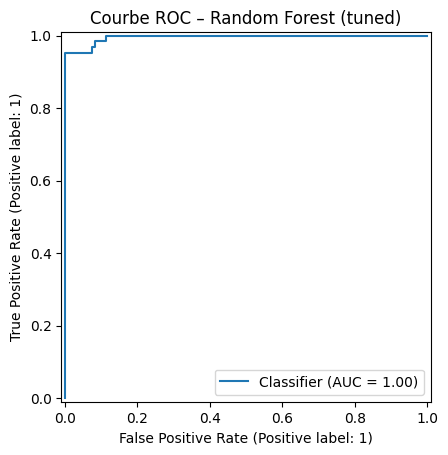

In [20]:
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_predictions(y_test, y_proba_best_rf)
plt.title("Courbe ROC – Random Forest (tuned)")
plt.show()
